This notebook plots the contact frequencies within TADs. The data must be prepared outside of the Jupyter notebook as it is much more efficient to run 100 SLURM jobs to calculate the necessary data. Please, check the scripts in /scripts/TADs

In [4]:
opts_pickle = ['/groups/tanaka/Publications/[2021 PNAS] Schloissnig/rebuttal/TADs_and_CNEs/contact_probabilities/merged.ext.dat']
opts_outdat = ['/groups/tanaka/Publications/[2021 PNAS] Schloissnig/rebuttal/TADs_and_CNEs/contact_probabilities/plotdata.pkl']
opts_outfig = ['/groups/tanaka/Publications/[2021 PNAS] Schloissnig/rebuttal/TADs_and_CNEs/contact_probabilities/plot.pdf']
opts_res    = [10000]

Reading the pickle file : /groups/tanaka/Publications/[2021 PNAS] Schloissnig/rebuttal/TADs_and_CNEs/contact_probabilities/merged.ext.dat
Preparing the data
Plotting the data
  Processing the group '<100k'
  Processing the group '100k-250k'
module 'cooltools.expected' has no attribute 'logbin_expected'
ERROR: An error occured. The slope of '100k-250k' was not calculated
  Processing the group '250k-500k'
module 'cooltools.expected' has no attribute 'logbin_expected'
ERROR: An error occured. The slope of '250k-500k' was not calculated
  Processing the group '500k-750k'
module 'cooltools.expected' has no attribute 'logbin_expected'
ERROR: An error occured. The slope of '500k-750k' was not calculated
  Processing the group '750k-1M'
module 'cooltools.expected' has no attribute 'logbin_expected'
ERROR: An error occured. The slope of '750k-1M' was not calculated
  Processing the group '1M-5M'
module 'cooltools.expected' has no attribute 'logbin_expected'
ERROR: An error occured. The slope o

No handles with labels found to put in legend.


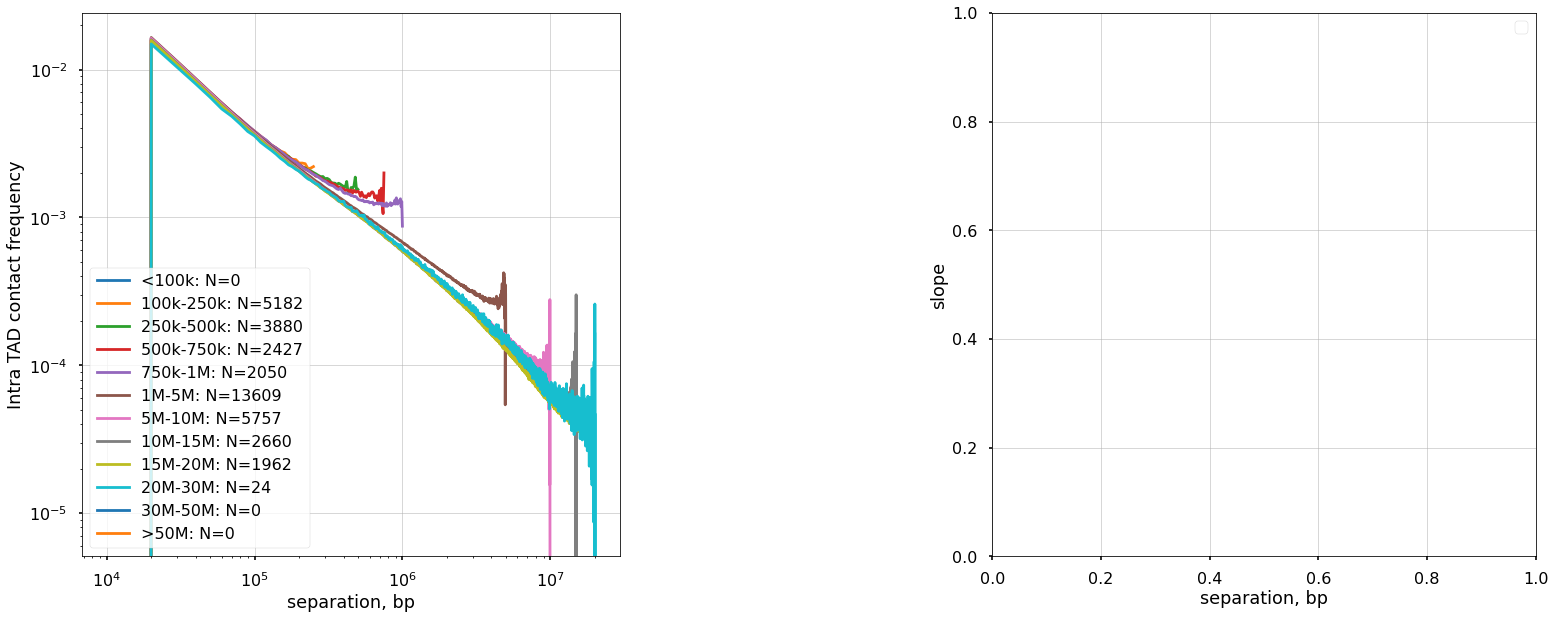

In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from matplotlib import colors

import numpy as np
import pandas as pd
import cooler
import cooltools
import cooltools.expected
import bioframe

import os
import pickle
import sys
import re


print(f'Reading the pickle file : {opts_pickle[0]}')
cvd = pd.read_pickle(opts_pickle[0])

if not 'tad_len' in cvd.columns:
    print('Assigning the TAD groups')
    tadgroup = []
    tadlen = []
    for i, row in cvd.iterrows():
        name = row['region']
        m = re.match('.+:([0-9]+)-([0-9]+)', name)
        if m:
            l = int(m.group(2)) - int(m.group(1))
            tadlen.append(l)
        else:
            print(f'Unmatched region: {name}')
            sys.exit(1)
        # Regions
        # <100k
        # 100-250k
        # 250-500k
        # 500-750k
        # 750-1000k
        # 1000-5000k
        # 5000-10000k
        # 10000-15000k
        # 15000-20000k
        # 20000-30000k
        # 30000-50000k
        # >50M
        if l < 100_000:
            tadgroup.append('<100k')
        elif l < 250_000:
            tadgroup.append('100k-250k')
        elif l < 500_000:
            tadgroup.append('250k-500k')
        elif l < 750_000:
            tadgroup.append('500k-750k')
        elif l < 1_000_000:
            tadgroup.append('750k-1M')
        elif l < 5_000_000:
            tadgroup.append('1M-5M')
        elif l < 10_000_000:
            tadgroup.append('5M-10M')
        elif l < 15_000_000:
            tadgroup.append('10M-15M')
        elif l < 20_000_000:
            tadgroup.append('15M-20M')
        elif l < 30_000_000:
            tadgroup.append('20M-30M')
        elif l < 50_000_000:
            tadgroup.append('30M-50M')
        else:
            tadgroup.append('>50M')

    print(f'Saving the data to {opts_outdat[0]}')
    cvd['tad_len'] = tadlen
    cvd['tad_group'] = tadgroup
    cvd.to_pickle(opts_outdat[0])


print('Preparing the data')
cvd_agg = (cvd.groupby(['diag','tad_group']).agg({'n_valid':'sum','count.sum':'sum','balanced.sum':'sum'}).reset_index())
cvd_agg['s_bp'] = (cvd_agg['diag'] * int(opts_res[0]))
cvd_agg['count.avg'] = (cvd_agg['count.sum'] / cvd_agg['n_valid'])
cvd_agg['balanced.avg'] = (cvd_agg['balanced.sum'] / cvd_agg['n_valid'])

print('Plotting the data')
f, (ax1, ax2) = plt.subplots(1,2, figsize=(30, 10))
for grp in ['<100k', '100k-250k', '250k-500k', '500k-750k', '750k-1M', '1M-5M', '5M-10M', '10M-15M', '15M-20M', '20M-30M', '30M-50M', '>50M']:
    print(f"  Processing the group '{grp}'")
    cvd_grp = cvd_agg[cvd_agg['tad_group'] == grp]
    tmp = cvd[cvd['tad_group'] == grp]
    nElem = len(tmp['region'].unique())
    ax1.loglog(cvd_grp['s_bp'], cvd_grp['balanced.avg'], label=f'{grp}: N={nElem}')

    cvd_grp = cvd[cvd['tad_group'] == grp]
    if cvd_grp.empty:
        continue

    try:
        lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd_grp)
        lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(lb_cvd, binned_exp_slope=lb_slopes)
        lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * int(opts_res[0])
        lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * int(opts_res[0])
        ax2.semilogx(lb_slopes_agg['s_bp'], lb_slopes_agg['slope'], alpha=0.5, label=f'{grp}')
    except Exception as e:
        print(e)
        print(f"ERROR: An error occured. The slope of '{grp}' was not calculated")

ax1.set(xlabel='separation, bp', ylabel='Intra TAD contact frequency')
ax1.set_aspect(1.0)
ax1.grid(lw=0.5)
ax1.legend()

ax2.set(xlabel='separation, bp', ylabel='slope')
ax2.set_aspect(1.0)
ax2.grid(lw=0.5)
ax2.legend()

f.savefig(opts_outfig[0])
